# Kickstarter ML Project

## Preparation

In [84]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

import sweetviz as sv
import json

### Load Data

In [2]:
# Load csv's and merge to a single dataframe

path = "/Users/bur.oez/neuefische/Kickstarter-ML-Project/data/*.csv" # Burak's path
#path = "data/*.csv" # Christian's path
#path = ".../*.csv"" # Matthias's path

all_files = glob.glob(path)
df_raw = pd.concat((pd.read_csv(f) for f in all_files))

### Overview

In [3]:
## Execute Sweetviz 
#my_report = sv.analyze(df_raw)
#my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

In [4]:
df_raw.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

## Data Cleaning

For safety, we operate on a copy of the data frame.

In [5]:
df = df_raw.copy()

For a basic feature analysis, we may focus on easily accessible features. Consequently, we drop the cols
- `blurb`, `slug`, `name` and `photo`, because they might only be exploitable through a semantic or context analysis,
- `currency_symbol`, `currency_trailing_code`, because they are redundant,
- `friends`, `is_starrable` and `permission`, because they do not contain any information,
- `disable_communication`, `is_backing` and `is_starred`, because they have an entry only for the same 300 data points and it is questionable whether the missing entries may be treated as one category; later on we might try this with one of them and drop the other two,  
- `urls`, `source_url` and `profile` because they do not contain additional information.
- `state_changed_at`, `spotlight` and `staff_pick` will be dropped, because the creator does not know them in adcvance,
- `created_at`, `launched_at` and `deadline` will be kept to calculate time-deltas for potential new features.

In [6]:
# dropping columns
df = df.drop(["blurb", "slug", "name", "photo", "currency_symbol", "currency_trailing_code", "state_changed_at",
              "friends", "permissions", "disable_communication", "is_backing", "is_starred","urls", 
              "source_url", "profile", "usd_type", "spotlight", "staff_pick", "is_starrable"], axis = 1)
df.head()

,backers_count,category,converted_pledged_amount,country,created_at,creator,currency,current_currency,deadline,fx_rate,goal,id,launched_at,location,pledged,state,static_usd_rate,usd_pledged
0,315,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,USD,1552539775,1.000000,28000.0,2108505034,1548223375,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",28645.0,live,1.000000,28645.000000
1,47,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,USD,1504976459,1.000000,1000.0,928751314,1502384459,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",1950.0,successful,1.000000,1950.000000
2,271,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,USD,1371013395,1.000000,15000.0,928014092,1368421395,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...",22404.0,successful,1.000000,22404.000000
3,3,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,USD,1489425776,1.308394,10000.0,596091328,1484245376,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",136.0,failed,1.216066,165.384934
4,3,"{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,USD,1357763527,1.000000,2800.0,998516049,1355171527,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",2820.0,successful,1.000000,2820.000000


Extract field and subfield ids from `category` (id and parent_id):

In [7]:
import ast
df.category =[ ast.literal_eval(x) for x in df.iloc[:,df.columns.tolist().index("category")]]

In [8]:
# checking which rows do not contain "parent_id" inside category dictionary
cat_list_parent_id = np.array(["parent_id" not in df.category.iloc[x].keys() for x in range(0,len(df.category))])
cat_list_parent_id.sum()

9041

In [9]:
df[cat_list_parent_id].iloc[0:3]

,backers_count,category,converted_pledged_amount,country,created_at,creator,currency,current_currency,deadline,fx_rate,goal,id,launched_at,location,pledged,state,static_usd_rate,usd_pledged
7,33,"{'id': 14, 'name': 'Music', 'slug': 'music', '...",660,US,1546965483,"{""id"":1945007923,""name"":""funktoast"",""is_regist...",USD,USD,1550067305,1.000000,400.0,1481360049,1547475305,"{""id"":2430903,""name"":""Kaysville"",""slug"":""kaysv...",660.0,successful,1.000000,660.000000
25,74,"{'id': 15, 'name': 'Photography', 'slug': 'pho...",2808,GB,1542202969,"{""id"":1471052173,""name"":""Tim Beale"",""is_regist...",GBP,USD,1544200381,1.308394,2000.0,865110410,1542385981,"{""id"":12056,""name"":""Bath"",""slug"":""bath-gb"",""sh...",2199.0,successful,1.301163,2861.258251
27,41,"{'id': 9, 'name': 'Fashion', 'slug': 'fashion'...",21161,GB,1551345787,"{""id"":103746336,""name"":""Jared Steadman"",""is_re...",GBP,CAD,1554490790,1.748586,20000.0,1889386358,1551898790,"{""id"":40611,""name"":""Winchester"",""slug"":""winche...",12102.0,live,1.315996,15926.177904


In [10]:
df.category.iloc[0]

{'id': 266,
 'name': 'Footwear',
 'slug': 'fashion/footwear',
 'position': 5,
 'parent_id': 9,
 'color': 16752598,
 'urls': {'web': {'discover': 'http://www.kickstarter.com/discover/categories/fashion/footwear'}}}

The `id` column represents each subcategory. `parent_id` represents each parent category, since the values for `id` start after `parent_id` values, we will use `id` to seperate each project into categories.

e `id` column represents each subcategory. `parent_id` represents each parent category, since the values for `id` start after `parent_id` values, we will use `id` to seperate each project into categories.

To projects without proper subcategorisation the `parent_id` is assigned. In addition `slug`is added for increased readability.

In [11]:
df["cat_id"] = [df.category.iloc[x]["id"] for x in range(0,len(df.category))]
df["slug"] = [df.category.iloc[x]["slug"] for x in range(0,len(df.category))]
categories = df.pop("category")

In [12]:
print(df.head(3))
print(df.shape)

   backers_count  converted_pledged_amount country  created_at  \
0            315                     28645      US  1541459205   
1             47                      1950      US  1501684093   
2            271                     22404      US  1348987533   

                                             creator currency  \
0  {"id":2094277840,"name":"Lucy Conroy","slug":"...      USD   
1  {"id":723886115,"name":"Lisa Vollrath","slug":...      USD   
2  {"id":323849677,"name":"Electra","is_registere...      USD   

  current_currency    deadline  fx_rate     goal          id  launched_at  \
0              USD  1552539775      1.0  28000.0  2108505034   1548223375   
1              USD  1504976459      1.0   1000.0   928751314   1502384459   
2              USD  1371013395      1.0  15000.0   928014092   1368421395   

                                            location  pledged       state  \
0  {"id":2462429,"name":"Novato","slug":"novato-c...  28645.0        live   
1  {"id":24

In [13]:
# check if currency - USD conversion with fx_rate and static_usd_rate matches usd_pledged value
print("pledged * static_usd_rate == usd_pledged")
print(df.eval("pledged * static_usd_rate == usd_pledged").value_counts())
print("pledged * fx_rate == usd_pledged")
print(df.eval("pledged * fx_rate == usd_pledged").value_counts())
print("converted_pledged_amount == usd_pledged")
print(df.eval("converted_pledged_amount == usd_pledged").value_counts())
print("pledged * static_usd_rate == converted_pledged_amount")
print(df.eval("pledged * static_usd_rate == converted_pledged_amount").value_counts())
print("pledged * fx_rate == converted_pledged_amount")
print(df.eval("pledged * fx_rate == converted_pledged_amount").value_counts())

pledged * static_usd_rate == usd_pledged
True     193838
False     15384
dtype: int64
pledged * fx_rate == usd_pledged
True     153961
False     55261
dtype: int64
converted_pledged_amount == usd_pledged
True     140490
False     68732
dtype: int64
pledged * static_usd_rate == converted_pledged_amount
True     140490
False     68732
dtype: int64
pledged * fx_rate == converted_pledged_amount
True     140473
False     68749
dtype: int64


In [14]:
print(df.eval("converted_pledged_amount == pledged + usd_pledged").value_counts())

False    190860
True      18362
dtype: int64


The values in `usd_pledged` do not match with the conversion of `pledged` using `fx_rate` or `static_usd_rate`. 

We decided to take the max value for these columns as the correct amount.

In [15]:
# checking whether pledged, usd_pledged or converted_pledged_amount has the highest values
df["max_pledged"] = [max(df.pledged.iloc[x], 
df.usd_pledged.iloc[x], 
df.converted_pledged_amount.iloc[x]) for x in range(0,len(df))]
df = df.drop(["usd_pledged", "pledged", "converted_pledged_amount"], axis = 1)

In [16]:
# in addition all other currency info can also be dropped
df = df.drop(["static_usd_rate", "fx_rate", "currency", "current_currency"], axis = 1)

In [17]:
# set checkpoint
df2 = df.copy()
df.head(2)
print(df.shape)

(209222, 13)


Now we will check whether `live` projects have met their goal and can be considered as `succesful`


In [18]:
df.loc[df['max_pledged'] >= df.goal, 'state'] = "successful"
#check whether there are live:successsful projects left
df.query("state == 'live' and max_pledged >= goal").state

Series([], Name: state, dtype: object)

Now we will drop all entries, which are not `successful` or `failed`


In [19]:
df.state.value_counts()

successful    119839
failed         75108
canceled        8456
live            5277
suspended        542
Name: state, dtype: int64

In [20]:
df = df[df.state != "canceled"]
df = df[df.state != "suspended"]
df = df[df.state != "live"]
df.state.unique()

array(['successful', 'failed'], dtype=object)

In [21]:
# Set checkpoint
df = df2.copy()
df.shape

(209222, 13)

Sort `countries` into categories US, NA, SEA, GB, ANZ, JP, EU:

In [22]:
pd.unique(df.country)

array(['US', 'GB', 'FR', 'AU', 'NZ', 'ES', 'IT', 'NO', 'NL', 'CA', 'SG',
       'MX', 'SE', 'IE', 'DE', 'BE', 'HK', 'AT', 'JP', 'DK', 'CH', 'LU'],
      dtype=object)

In [23]:
df.country.replace({'HK':"SEA", 'NL':"EU", 'AU':"ANZ", 'DE':"EU", "CA":"NA", 'SE':"EU",
                    'BE':"EU", 'MX':"NA", 'CH':"EU", 'SG':"SEA", 'FR':"EU", 'IT':"EU",
                    'DK':"EU", 'LU':"EU", 'NO':"EU", 'ES':"EU", 'IE':"EU", 'NZ':"ANZ", 
                    'AT':"EU"}, inplace = True)

Turn entries of `created_at`, `launched`, `deadline` into datetime:

In [24]:
df.created_at = pd.to_datetime(df.iloc[:,df.columns.tolist().index("created_at")],unit='s')
df.launched_at = pd.to_datetime(df.iloc[:,df.columns.tolist().index("launched_at")],unit='s')
df.deadline = pd.to_datetime(df.iloc[:,df.columns.tolist().index("deadline")],unit='s')
#df.state_changed_at = pd.to_datetime(df.iloc[:,df.columns.tolist().index("state_changed_at")],unit='s')
df.head()

,backers_count,country,created_at,creator,deadline,goal,id,launched_at,location,state,cat_id,slug,max_pledged
0,315,US,2018-11-05 23:06:45,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",2019-03-14 05:02:55,28000.0,2108505034,2019-01-23 06:02:55,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",live,266,fashion/footwear,28645.000000
1,47,US,2017-08-02 14:28:13,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",2017-09-09 17:00:59,1000.0,928751314,2017-08-10 17:00:59,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",successful,273,games/playing cards,1950.000000
2,271,US,2012-09-30 06:45:33,"{""id"":323849677,""name"":""Electra"",""is_registere...",2013-06-12 05:03:15,15000.0,928014092,2013-05-13 05:03:15,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...",successful,43,music/rock,22404.000000
3,3,GB,2017-01-07 09:11:11,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",2017-03-13 17:22:56,10000.0,596091328,2017-01-12 18:22:56,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",failed,273,games/playing cards,165.384934
4,3,US,2012-12-06 18:04:31,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",2013-01-09 20:32:07,2800.0,998516049,2012-12-10 20:32:07,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",successful,48,publishing/nonfiction,2820.000000


In [25]:
# set checkpoint
df2 = df.copy()
df.shape

(209222, 13)

Check for `id` copies and remove if they refer to the same data point: multiplicities of entries:

In [26]:
print(*df.id.value_counts().unique())

3 2 1


List of multiply used `id` entries:

In [27]:
dic = df.id.value_counts()
multiples = np.array([key for key in dic.keys() if dic[key] > 1])
len(multiples)

26957

They don't differ in any features, except one.

In that case, only one of the rows with the same `id` entry need to be kept.

In [28]:
df.drop_duplicates(subset = "id", keep = "first", inplace = True)

In [29]:
df.shape

(182264, 13)

Now we will take a look at `location` and try to extract some meaningful information.

Fist we will drop NaN rows and then convert the `json-str` into a dictonary to extract keys and values.

In [30]:
df.location.isnull().sum()

224

In [31]:
df.dropna(axis = 0, subset = ["location"], inplace = True)

In [32]:
df.location =[json.loads(x) for x in df.location]

In [33]:
df["location_type"] = [df.location.iloc[x]["type"] for x in range(0,len(df.location))]
df["location_city"] = [df.location.iloc[x]["short_name"] for x in range(0,len(df.location))]
df["location_state"] = [df.location.iloc[x]["state"] for x in range(0,len(df.location))]
location = df.pop("location")

In [34]:
df.location_city.value_counts()

Los Angeles, CA         8577
New York, NY            6771
London, UK              6528
Chicago, IL             3429
San Francisco, CA       2934
                        ... 
North Yarmouth, ME         1
Shantiniketan, India       1
Pennsboro, WV              1
Wiley Ford, WV             1
Blacklion, Ireland         1
Name: location_city, Length: 14514, dtype: int64

In [35]:
df.location_state.value_counts()

CA                   23857
England              16576
NY                   14840
TX                    7542
FL                    6353
                     ...  
Acre                     1
Armavir                  1
Nakhon Ratchasima        1
Siparia                  1
Haryana                  1
Name: location_state, Length: 1152, dtype: int64

In [36]:
df.location_type.value_counts()

Town             168846
County             6797
Suburb             4623
LocalAdmin         1059
Zip                 447
Island              229
Country              20
Miscellaneous        15
Estate                4
Name: location_type, dtype: int64

In [37]:
# set checkpoint
df2 = df.copy()
df.shape

(182040, 15)

## Data Exploration
After cleaning the data, we will look into the distribution of the features and look into possible relationships

Categories in category:  169


<AxesSubplot:title={'center':'Top 20 most popular categories'}>

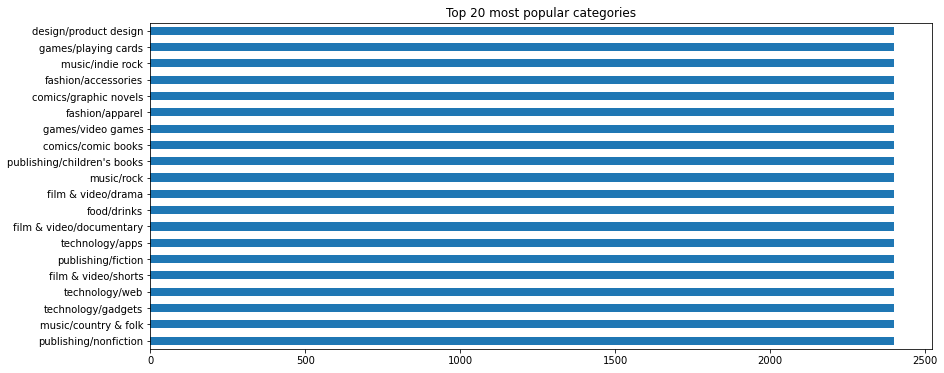

In [48]:
print('Categories in category: ', df['slug'].nunique())
df['slug'].value_counts()[:20].plot(kind='barh', 
                                        figsize=(14,6), 
                                        title='Top 20 most popular categories')

Number of unique countries:  7


<AxesSubplot:title={'center':'Top 7countries'}>

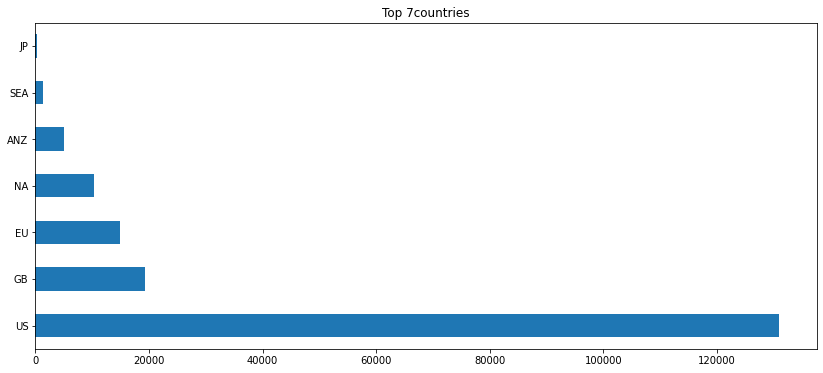

In [50]:
print('Number of unique countries: ', df['country'].nunique())
df['country'].value_counts()[:15].plot(kind='barh', 
                                       figsize=(14,6), 
                                       title='Top 7countries')

In [53]:
print('The average Kickstarter campaign has {} USD pledged, {} backers and a goal of {} USD.'.format(round(df['max_pledged'].mean(), 2),
                                                                                               int(df['backers_count'].mean()),
                                                                                               round(df['goal'].mean(), 2)))

The average Kickstarter campaign has 16209.27 USD pledged, 133 backers and a goal of 52661.41 USD.


In [54]:
# Create a feature for average amount pledged per backer
df['avg_pledged'] = df['max_pledged'] / df['backers_count']

# Take care of infinite values and campaigns with 0 backers
df['avg_pledged'].fillna(0, inplace=True)
df.replace(to_replace=[np.inf, -np.inf], value=0, inplace=True)

print('Kickstarter backers pledge {} USD to a campaign on average'.format(round(df['avg_pledged'].mean(), 2)))

Kickstarter backers pledge 106.47 USD to a campaign on average


In [58]:
# Get a list of all categories in 'main_category'
cat_list = list(df['slug'].unique())

# Create a mapping of the average pledged per backer for every category
pledge_mapping = dict()
for category in cat_list:
    cat_df = df[df['slug'] == category]
    pledge_mapping.update({category : cat_df['avg_pledged'].mean()})
    

,technology/sound,crafts/pottery,design/product design,technology/robots,technology/makerspaces,technology/3d printing,technology,technology/camera equipment,technology/hardware,technology/gadgets,...,music/r&b,publishing/young adult,music/comedy,journalism/photo,journalism/video,music/hip-hop,publishing/poetry,crafts/candles,food/bacon,crafts/crochet
avg_pledged,867.383855,486.955813,465.776539,454.798701,452.01984,440.085486,426.819789,411.943024,247.041335,244.408842,...,41.846881,41.707644,40.42765,38.306866,35.090483,34.638978,33.682107,26.798604,24.803273,22.722898


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'technology/sound'),
  Text(1, 0, 'crafts/pottery'),
  Text(2, 0, 'design/product design'),
  Text(3, 0, 'technology/robots'),
  Text(4, 0, 'technology/makerspaces'),
  Text(5, 0, 'technology/3d printing'),
  Text(6, 0, 'technology'),
  Text(7, 0, 'technology/camera equipment'),
  Text(8, 0, 'technology/hardware'),
  Text(9, 0, 'technology/gadgets'),
  Text(10, 0, 'technology/fabrication tools'),
  Text(11, 0, 'publishing'),
  Text(12, 0, 'technology/wearables'),
  Text(13, 0, 'technology/diy electronics'),
  Text(14, 0, 'film & video'),
  Text(15, 0, 'film & video/documentary'),
  Text(16, 0, 'design'),
  Text(17, 0, 'film & video/shorts'),
  Text(18, 0, 'fashion'),
  Text(19, 0, 'fashion/footwear')])

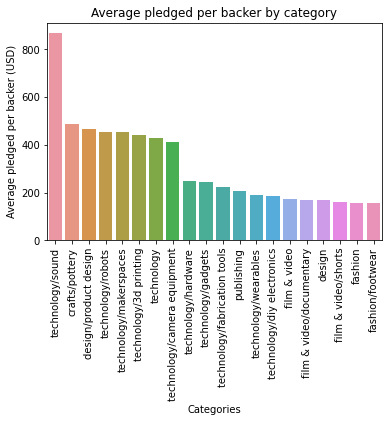

In [91]:
# Visualize the results
pledge_df = pd.DataFrame(pledge_mapping, index=['avg_pledged'])
pledge_df.sort_values('avg_pledged', axis=1, inplace=True, ascending=False)
display(pledge_df.head())
dfplot = pledge_df.iloc[:,: 20];
sns.barplot(data = dfplot);
plt.title('Average pledged per backer by category')
plt.xlabel('Categories')
plt.ylabel('Average pledged per backer (USD)')
plt.xticks(rotation="vertical")


### Location score

In [39]:
dic = {x:0 for x in df.location_city}

dic.update(df.query('state == 1').location_city.value_counts().to_dict())
df['location_score'] = df.location_city.replace(dic)

df['location_score'] = [max(0, x-1) for x in df.location_score]

### Goal cutoff and log

The distribution of `goal` is sporadic:

In [40]:
df.goal.max(), df.goal.min(), df.goal.mean(), df.goal.median(), df.goal.std()

(100000000.0, 0.01, 52661.41345132938, 5000.0, 1238320.2298351228)

Let us see how many data points get lost for certain `goal` cutoffs:

In [41]:
print('cutoff = 10,000,000:', df.query('goal > 10000000').goal.count())
print('cutoff = 5,000,000:', df.query('goal > 5000000').goal.count())
print('cutoff = 2,000,000:', df.query('goal > 2000000').goal.count())
print('cutoff = 1,000,000:', df.query('goal > 1000000').goal.count())

cutoff = 10,000,000: 85
cutoff = 5,000,000: 178
cutoff = 2,000,000: 383
cutoff = 1,000,000: 671


We cut off at 10,000,000:

In [42]:
df = df.query('goal < 10000001')

In addition, we take the log:

In [43]:
df.goal = df.eval('log(goal)')

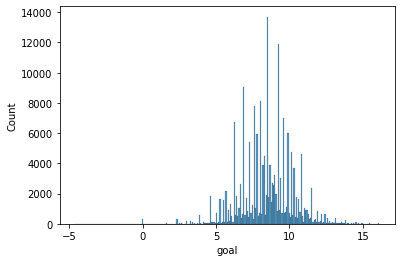

In [44]:
import seaborn as sns
sns.histplot(df.goal);

### Success rate

In [45]:
df['creator_id'] = [x[x.find(':')+1 : x.find(',')] for x in df.creator]

dic_suc = {id:0 for id in df.creator_id.unique()}
dic_fai = {id:0 for id in df.creator_id.unique()}
dic_suc.update(df.query('state == "successful"').creator_id.value_counts().to_dict())
dic_fai.update(df.query('state == "failed"').creator_id.value_counts().to_dict())

df['projects_successful'] = df.creator_id
df['projects_failed'] = df.creator_id

In [46]:
df.projects_successful.replace(dic_suc, inplace=True)
df.projects_failed.replace(dic_fai, inplace=True)

In [47]:
df['projects_successful_nm'] = [max(0, x-1) for x in df.projects_successful]
df['projects_failed_nm'] = [max(0, x-1) for x in df.projects_failed]

Drop `creator_id`:

In [48]:
df.drop('creator_id', axis=1, inplace=True)

In [49]:
df.projects_successful_nm, df.projects_failed_nm 

(0       0
 1       6
 2       0
 3       0
 4       0
        ..
 3786    0
 3788    0
 3789    0
 3790    1
 3791    0
 Name: projects_successful_nm, Length: 181955, dtype: int64,
 0       0
 1       0
 2       0
 3       1
 4       0
        ..
 3786    0
 3788    0
 3789    0
 3790    0
 3791    0
 Name: projects_failed_nm, Length: 181955, dtype: int64)

### Gender

In [50]:
df['creator_name'] = [x[x.find('":"')+3 : x.find('","')].split(' ')[0].lower() for x in df.creator]

In [51]:
males = pd.read_csv('male.txt', sep='\n')
females = pd.read_csv('female.txt', sep='\n')

dic_names = {x.lower():1 for x in males['# List of common male names.'].iloc[4:]}
dic_names.update({x.lower():0 for x in females['# List of common female names.'].iloc[4:]})

dic = {x:2 for x in df.creator_name}
dic.update(dic_names)

FileNotFoundError: [Errno 2] No such file or directory: 'male.txt'

In [52]:
df['gender'] = df.creator_name.replace(dic)

KeyboardInterrupt: 

In [ ]:
# Save cleaned data
df.to_csv('data_cleaned/kickstarter_cleaned.csv')

In [53]:
df['month_created'] = df['created_at'].dt.month
df['month_launced'] = df['launched_at'].dt.month
df['month_deadline'] = df['deadline'].dt.month

In [54]:
df['delta_public'] = (df['created_at'] - df['launched_at']) / pd.offsets.Day(-1)
df['delta_funding'] = (df['launched_at'] - df['deadline']) / pd.offsets.Day(-1)

In [55]:
df['delta_public'] = df.delta_public.round(0)
df['delta_funding'] = df.delta_funding.round(0)

In [ ]:
#We will also take a look into, whether a project has been succesful prior to the deadline.
#print(sum(df["deadline"] > df["state_changed_at"]))
#print(sum(df["deadline"] <= df["state_changed_at"]))

It seems like the state of the project is either changed at the exact same time of the deadline or afterwards. Only 0.8% have reached their goal before the deadline. 

A creator can extend the goals of the project further, if the sum is succesfully campaigned before the deadline. There is no indication in our dataset, whether this has been done for a project.

In [56]:
df = df.drop(["created_at", "deadline", "launched_at",
              #"state_changed_at"
             ], axis = 1)
df.head(3)

,backers_count,country,creator,goal,id,state,cat_id,slug,max_pledged,location_type,...,projects_successful,projects_failed,projects_successful_nm,projects_failed_nm,creator_name,month_created,month_launced,month_deadline,delta_public,delta_funding
0,315,US,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",10.239960,2108505034,live,266,fashion/footwear,28645.0,Town,...,0,0,0,0,lucy,11,1,3,78.0,50.0
1,47,US,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",6.907755,928751314,successful,273,games/playing cards,1950.0,Town,...,7,0,6,0,lisa,8,8,9,8.0,30.0
2,271,US,"{""id"":323849677,""name"":""Electra"",""is_registere...",9.615805,928014092,successful,43,music/rock,22404.0,Suburb,...,1,0,0,0,electra,9,5,6,225.0,30.0


In [57]:
df.columns

Index(['backers_count', 'country', 'creator', 'goal', 'id', 'state', 'cat_id',
       'slug', 'max_pledged', 'location_type', 'location_city',
       'location_state', 'location_score', 'projects_successful',
       'projects_failed', 'projects_successful_nm', 'projects_failed_nm',
       'creator_name', 'month_created', 'month_launced', 'month_deadline',
       'delta_public', 'delta_funding'],
      dtype='object')

In [58]:
# set Checkpoint after creating time-frame features
df2 = df.copy()

## Predictive Modelling

Now we will construct models to predict the success of each project based on the features obtained/ created. 

Therefore our target feature will be `state`
.

In [59]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42

In [60]:
df.head()

,backers_count,country,creator,goal,id,state,cat_id,slug,max_pledged,location_type,...,projects_successful,projects_failed,projects_successful_nm,projects_failed_nm,creator_name,month_created,month_launced,month_deadline,delta_public,delta_funding
0,315,US,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",10.239960,2108505034,live,266,fashion/footwear,28645.000000,Town,...,0,0,0,0,lucy,11,1,3,78.0,50.0
1,47,US,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",6.907755,928751314,successful,273,games/playing cards,1950.000000,Town,...,7,0,6,0,lisa,8,8,9,8.0,30.0
2,271,US,"{""id"":323849677,""name"":""Electra"",""is_registere...",9.615805,928014092,successful,43,music/rock,22404.000000,Suburb,...,1,0,0,0,electra,9,5,6,225.0,30.0
3,3,GB,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",9.210340,596091328,failed,273,games/playing cards,165.384934,Town,...,0,2,0,1,artur,1,1,3,5.0,60.0
4,3,US,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",7.937375,998516049,successful,48,publishing/nonfiction,2820.000000,Town,...,1,0,0,0,dawn,12,12,1,4.0,30.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181955 entries, 0 to 3791
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   backers_count           181955 non-null  int64  
 1   country                 181955 non-null  object 
 2   creator                 181955 non-null  object 
 3   goal                    181955 non-null  float64
 4   id                      181955 non-null  int64  
 5   state                   181955 non-null  object 
 6   cat_id                  181955 non-null  int64  
 7   slug                    181955 non-null  object 
 8   max_pledged             181955 non-null  float64
 9   location_type           181955 non-null  object 
 10  location_city           181955 non-null  object 
 11  location_state          181906 non-null  object 
 12  location_score          181955 non-null  int64  
 13  projects_successful     181955 non-null  int64  
 14  projects_failed       

In [62]:
df_pred = df.copy()

In [63]:
# Transform type objects to string

df_pred['country'] = df_pred['country'].astype(str)
df_pred['slug'] = df_pred['slug'].astype(str)
df_pred['location_type'] = df_pred['location_type'].astype(str)
df_pred['location_city'] = df_pred['location_city'].astype(str)
df_pred['location_state'] = df_pred['location_state'].astype(str)

Since most of the project originate from the US, and the information from the `location_state` does not work for countries w/o a federal system, we will change the value or `location_state`.

If a project originates from the US, the state will be stored, if from another country, the name of the country. We will also drop the feature `location_city`, because there are over 14,000 different values and would hinder our ability to predict. 

The location information is still available in the features `country`, `location_state` and `location_type`-

In [64]:
for i in range(len(df.location_city)):
    if df.country.iloc[i] != "US":
        
        temp = df.location_city.iloc[i].split(", ")
        if len(temp) == 2:
            df_pred.location_state.iloc[i] = temp[1]
        else:
            df_pred.location_state.iloc[i] = temp[0]
    else: 
        pass
df_pred.drop(["location_city"], axis=1, inplace = True);

/Users/bur.oez/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [65]:
# Creating list for categorical features 
cat_features = list(df_pred.columns[df_pred.dtypes==object])
cat_features.remove('state')
cat_features.append('id')
cat_features.append('cat_id')
cat_features

['country',
 'creator',
 'slug',
 'location_type',
 'location_state',
 'creator_name',
 'id',
 'cat_id']

In [66]:
# Creating list for numerical predictors/features
num_features = list(df_pred.columns[df_pred.dtypes!=object])
num_features.remove('id')
num_features.remove('cat_id')
num_features

['backers_count',
 'goal',
 'max_pledged',
 'location_score',
 'projects_successful',
 'projects_failed',
 'projects_successful_nm',
 'projects_failed_nm',
 'month_created',
 'month_launced',
 'month_deadline',
 'delta_public',
 'delta_funding']

In [73]:
print(df.columns.to_series().groupby(df.dtypes).groups)

{int64: ['backers_count', 'id', 'cat_id', 'location_score', 'projects_successful', 'projects_failed', 'projects_successful_nm', 'projects_failed_nm', 'month_created', 'month_launced', 'month_deadline'], float64: ['goal', 'max_pledged', 'delta_public', 'delta_funding'], object: ['country', 'creator', 'state', 'slug', 'location_type', 'location_city', 'location_state', 'creator_name']}


## Data Preprocessing and target formulation

In [67]:
# Define features and target variable
features = df_pred.drop('state', axis=1)
target = df_pred['state']

In [ ]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features)
# Convert target feature into binary
target = target.apply(lambda x: "pos" if x == 'successful' else "neg")

In [66]:
# Print the number of features after one-hot encoding
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

1193 total features after one-hot encoding.


In [67]:
np.unique(target)

array(['neg', 'pos'], dtype=object)

## Train-Test-Split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RSEED)

In [69]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (136109, 1193)
X_test shape: (34028, 1193)
y_train shape: (136109,)
y_test shape: (34028,)


## Normalizing Numerical Features

In [70]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['goal']
X_train['numerical'] = scaler.fit_transform(X_train[numerical])
X_test['numerical'] = scaler.transform(X_test[numerical])

<ipython-input-70-d0fea70d0133>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['numerical'] = scaler.fit_transform(X_train[numerical])
<ipython-input-70-d0fea70d0133>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['numerical'] = scaler.transform(X_test[numerical])


## Training and Prediction Pipeline

In [71]:
from sklearn.metrics import fbeta_score, accuracy_score

# Define a train and evaluation function 
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
   # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5, pos_label="pos")
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5, pos_label="pos")
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

## Model evaluation


### Naive Predictor

In [72]:
target.value_counts([0])

pos    0.564698
neg    0.435302
Name: state, dtype: float64

In [73]:
# TODO: Calculate accuracy
accuracy = 0.564698 

# TODO: Calculating precision
precision = 0.5

# TODO: Calculating recall
recall = 1

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5647, F-score: 0.5556]


### Model Application

In [74]:
from time import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [75]:
clf_dtree = DecisionTreeClassifier(random_state=101)
clf_svc = SVC(random_state=101)
clf_aboost = AdaBoostClassifier(random_state=101)
clf_logreg = LogisticRegression(random_state=101)
clf_multiNB = MultinomialNB()

In [78]:
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_25 = int(round(len(X_train) / 4))
samples_100 = len(X_train)

In [77]:
results = {}
for clf in [clf_logreg, clf_dtree, clf_multiNB]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 1361 samples.
LogisticRegression trained on 13611 samples.
LogisticRegression trained on 136109 samples.
DecisionTreeClassifier trained on 1361 samples.
DecisionTreeClassifier trained on 13611 samples.
DecisionTreeClassifier trained on 136109 samples.
MultinomialNB trained on 1361 samples.
MultinomialNB trained on 13611 samples.
MultinomialNB trained on 136109 samples.


In [81]:
results["clf_svc"] = {}
results["clf_svc"][2] = \
train_predict(clf_svc,samples_25, X_train, y_train, X_test, y_test)

SVC trained on 34027 samples.


In [82]:
results

{'LogisticRegression': {0: {'train_time': 0.14533782005310059,
   'pred_time': 0.5248539447784424,
   'acc_train': 0.5833333333333334,
   'acc_test': 0.5629775479017279,
   'f_train': 0.6363636363636365,
   'f_test': 0.616897126921665},
  1: {'train_time': 0.42053699493408203,
   'pred_time': 0.6017630100250244,
   'acc_train': 0.5833333333333334,
   'acc_test': 0.5629775479017279,
   'f_train': 0.6363636363636365,
   'f_test': 0.616897126921665},
  2: {'train_time': 6.640020132064819,
   'pred_time': 0.25148582458496094,
   'acc_train': 0.5833333333333334,
   'acc_test': 0.5629775479017279,
   'f_train': 0.6363636363636365,
   'f_test': 0.616897126921665}},
 'DecisionTreeClassifier': {0: {'train_time': 0.05267810821533203,
   'pred_time': 0.3929593563079834,
   'acc_train': 1.0,
   'acc_test': 0.9430762901140237,
   'f_train': 1.0,
   'f_test': 0.94420534732993},
  1: {'train_time': 0.43224501609802246,
   'pred_time': 0.5890278816223145,
   'acc_train': 1.0,
   'acc_test': 0.98530621

### Metric evaluation and Plotting functions for model performance visualisation

In [83]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score


def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()


def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (12,10))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()
    

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  

### Supervised Model performance

KeyError: 0

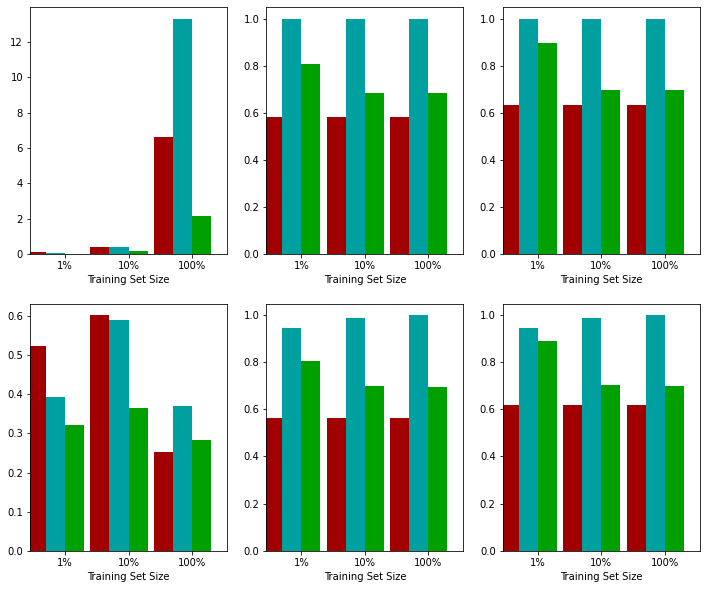

In [84]:
evaluate(results, accuracy, fscore)

In [85]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
train_time,0.145338,0.420537,6.640020
pred_time,0.524854,0.601763,0.251486
acc_train,0.583333,0.583333,0.583333
acc_test,0.562978,0.562978,0.562978
f_train,0.636364,0.636364,0.636364
f_test,0.616897,0.616897,0.616897


DecisionTreeClassifier


,1%,10%,100%
train_time,0.052678,0.432245,13.280619
pred_time,0.392959,0.589028,0.370811
acc_train,1.000000,1.000000,1.000000
acc_test,0.943076,0.985306,0.996150
f_train,1.000000,1.000000,1.000000
f_test,0.944205,0.985865,0.996100


MultinomialNB


,1%,10%,100%
train_time,0.035707,0.162353,2.164744
pred_time,0.321262,0.366265,0.282857
acc_train,0.806667,0.686667,0.686667
acc_test,0.805219,0.698190,0.692107
f_train,0.896296,0.699440,0.699440
f_test,0.890085,0.699850,0.695642


clf_svc


,100%
acc_test,0.562978
acc_train,0.583333
f_test,0.616897
f_train,0.636364
pred_time,1091.093343
train_time,863.707451


In [ ]:
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_dtree,clf_logreg, clf_svc]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

### Extracting Feature Importance

In [ ]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)